In [ ]:
import io
from PIL import Image
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import json
import torch.utils.data as tdata
from tqdm import tqdm
from torch import optim 
import torch.nn as nn

from transformers.models.detr.feature_extraction_detr import rgb_to_id
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [ ]:
#%pip install -qq -U diffusers datasets transformers accelerate ftfy 

#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

#%pip install timm

In [ ]:
seed_value = 7
torch.manual_seed(seed_value)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)

In [ ]:
device= torch.device("cuda:0")
device

In [ ]:
SIZE=640

In [ ]:

processor = AutoImageProcessor.from_pretrained("RavenOnur/Sign-Language")
model = AutoModelForImageClassification.from_pretrained("RavenOnur/Sign-Language").to(device)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Francesco/sign-language-sokdr")

In [131]:
class Dataset(tdata.Dataset):
    def __init__(self,dataset,processor):
        self.processor=processor

        self.image=[]
        self.type=[]
        for id in range(len(dataset['image'])):
            if dataset['objects'][id]['category'][0] <25:
                self.image.append(dataset['image'][id])
                self.type.append(dataset['objects'][id]['category'][0]-1)
        self.len=len(self.image)
    
    def __getitem__(self, id):
        return  torch.from_numpy(np.array(self.image[id])).to(device),torch.tensor(self.type[id]).to(device)
    

    def __len__(self):
        return self.len
    


In [132]:
train_set=Dataset(dataset['train'][0:504],processor=processor)

train_data=tdata.DataLoader(train_set,batch_size=4)
np.see

In [ ]:
x=processor(dataset['train']['image'][70], return_tensors="pt")
y=model(x['pixel_values'].to(device))


In [118]:
optimize=optim.Adam(model.parameters(),lr=0.001)

criterion=nn.CrossEntropyLoss()

100%|██████████| 10/10 [02:48<00:00, 16.80s/it]


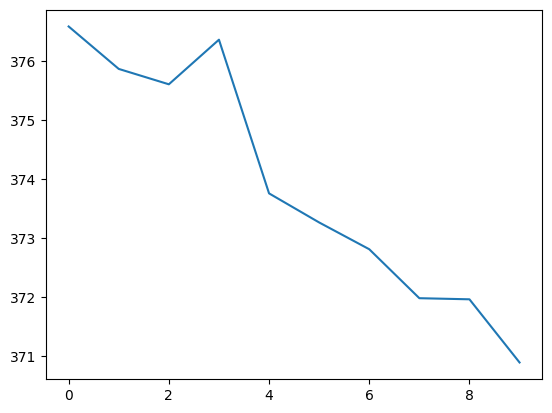

In [137]:
EPOCH=[]
LOSS=[]

for epoch in tqdm(range(10)):
    model.train()
    tloss=0
    for x,y in train_data:
        optimize.zero_grad()
        input=processor(images=x, return_tensors="pt")
        py=model(input['pixel_values'].to(device))
        loss=criterion(py.logits,y)
        loss.backward()
        optimize.step()

        tloss+=loss.item()

    EPOCH.append(epoch)
    LOSS.append(tloss)

plt.plot(EPOCH,LOSS)
plt.show()